In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError, URLError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'zomato-bangalore-restaurants:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F153420%2F352891%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240728%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240728T094931Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D58855eeb05febc414cdaa1938f72a6a3018388ba7cfff89317c0dcbd2d0a6826e6775112658cbd9877dbfa1b30c7b6b7dbbe83c5d3e29f1ffb14614852d5af9e99b0370b37d9207ab35cd38901fd6abad7394180710f21008a504fb3f10769630a765c6d9f0a44f4bae5efc45050c364c1ad66f6a9e45b32f42a1eb022be557f8a75d0a88f15ad0f57780d8d32b1e2723960e63bd0ebaffc753eacfb212ecbdedce6fc3b066fa6bee5d835e68d0da2d92782874cb6e95f4b63477dcd5887e42254fb8ba7c03f250b9b71833cfc8dcd01223b4347998a9f5cf48f2bdcf7efda2ef3fd650e98c371561d69534bf234ad5d09b51492d7a5f0b10049321b19720964'

DATA_DIRECTORY = './data'

shutil.rmtree(DATA_DIRECTORY, ignore_errors=True)
os.makedirs(DATA_DIRECTORY, exist_ok=True)

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = os.path.basename(urlparse(download_url).path)
    destination_path = os.path.join(DATA_DIRECTORY, directory)
    
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers.get('content-length')
            if total_length:
                total_length = int(total_length)
                print(f'Downloading {directory}, {total_length} bytes compressed')
            else:
                print(f'Downloading {directory}')
                
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while data:
                dl += len(data)
                tfile.write(data)
                if total_length:
                    done = int(50 * dl / total_length)
                    sys.stdout.write(f"\r[{'=' * done}{' ' * (50 - done)}] {dl} bytes downloaded")
                else:
                    sys.stdout.write(f"\r{dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            
            tfile.flush()
            tfile.seek(0)

            if filename.endswith('.zip'):
                with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
            elif filename.endswith(('.tar.gz', '.tgz')):
                with tarfile.open(tfile.name, 'r:gz') as tar:
                    tar.extractall(destination_path)
            elif filename.endswith('.tar'):
                with tarfile.open(tfile.name, 'r') as tar:
                    tar.extractall(destination_path)
            else:
                raise ValueError(f'Unsupported file format: {filename}')

            print(f'\nDownloaded and uncompressed: {directory}')

    except (HTTPError, URLError) as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}: {e}')
    except (OSError, ValueError) as e:
        print(f'Failed to load {download_url} to path {destination_path}: {e}')

print('Data source import complete.')


[==================================================] 93341357 bytes downloaded
Downloaded and uncompressed: zomato-bangalore-restaurants
Data source import complete.


In [2]:
df = pd.read_csv("./data/zomato-bangalore-restaurants/zomato.csv")
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [3]:
df.shape

(51717, 17)

In [4]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [5]:
df = df.drop(['url','address','phone','menu_item',"dish_liked",'reviews_list'],axis = 1)
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,approx_cost(for two people),listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1/5,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1/5,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8/5,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,Banashankari,Quick Bites,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8/5,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600,Buffet,Banashankari


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         51717 non-null  object
 1   online_order                 51717 non-null  object
 2   book_table                   51717 non-null  object
 3   rate                         43942 non-null  object
 4   votes                        51717 non-null  int64 
 5   location                     51696 non-null  object
 6   rest_type                    51490 non-null  object
 7   cuisines                     51672 non-null  object
 8   approx_cost(for two people)  51371 non-null  object
 9   listed_in(type)              51717 non-null  object
 10  listed_in(city)              51717 non-null  object
dtypes: int64(1), object(10)
memory usage: 4.3+ MB


## Dropping the Duplicates

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(51609, 11)

In [8]:

df.drop(columns=['rest_type'], inplace=True, axis = 1)


## Cleaning Rate Column 

In [9]:
df.rate.unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', nan, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

## Removing "NEW" ,  "-" and "/5" from Rate Column

In [10]:
def fixing_rate(value):
  if(value=='NEW' or value=='-'):
    return np.nan
  else:
    value = str(value).split('/')
    value = value[0]
    return float(value)

df['rate'] = df['rate'].apply (fixing_rate)
df['rate'].head()

0    4.1
1    4.1
2    3.8
3    3.7
4    3.8
Name: rate, dtype: float64

In [11]:
df['rate']

0        4.1
1        4.1
2        3.8
3        3.7
4        3.8
        ... 
51712    3.6
51713    NaN
51714    NaN
51715    4.3
51716    3.4
Name: rate, Length: 51609, dtype: float64

## Filling Null Values in Rate Column with Mean

In [12]:
df.rate.isnull().sum()

10019

In [13]:
df["rate"].fillna(df['rate'].mean(), inplace=True)
df['rate'].isnull().sum()


0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51609 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         51609 non-null  object 
 1   online_order                 51609 non-null  object 
 2   book_table                   51609 non-null  object 
 3   rate                         51609 non-null  float64
 4   votes                        51609 non-null  int64  
 5   location                     51588 non-null  object 
 6   cuisines                     51564 non-null  object 
 7   approx_cost(for two people)  51265 non-null  object 
 8   listed_in(type)              51609 non-null  object 
 9   listed_in(city)              51609 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 4.3+ MB


## Dropping Null Values

In [15]:
df.dropna(inplace=True)
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,approx_cost(for two people),listed_in(type),listed_in(city)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,"North Indian, Rajasthani",600,Buffet,Banashankari


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51246 entries, 0 to 51716
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   name                         51246 non-null  object 
 1   online_order                 51246 non-null  object 
 2   book_table                   51246 non-null  object 
 3   rate                         51246 non-null  float64
 4   votes                        51246 non-null  int64  
 5   location                     51246 non-null  object 
 6   cuisines                     51246 non-null  object 
 7   approx_cost(for two people)  51246 non-null  object 
 8   listed_in(type)              51246 non-null  object 
 9   listed_in(city)              51246 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 4.3+ MB


In [17]:
df.rename(columns = {'approx_cost(for two people)':'2PlatesCost' , 'listed_in(type)': 'Type'}, inplace = True)
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type,listed_in(city)
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800,Buffet,Banashankari
1,Spice Elephant,Yes,No,4.1,787,Banashankari,"Chinese, North Indian, Thai",800,Buffet,Banashankari
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Mexican, Italian",800,Buffet,Banashankari
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300,Buffet,Banashankari
4,Grand Village,No,No,3.8,166,Basavanagudi,"North Indian, Rajasthani",600,Buffet,Banashankari


In [18]:
df['location'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Sarjapur Road', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'RT Nagar',
       'MG Road', 'Brigade Road', 'Lavelle Road', 'Church Street',
       'Ulsoor', 'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'HBR Layout', 'Domlur',
       'Ejipura', 'Jeevan Bhima

In [19]:
df['listed_in(city)'].unique()

array(['Banashankari', 'Bannerghatta Road', 'Basavanagudi', 'Bellandur',
       'Brigade Road', 'Brookefield', 'BTM', 'Church Street',
       'Electronic City', 'Frazer Town', 'HSR', 'Indiranagar',
       'Jayanagar', 'JP Nagar', 'Kalyan Nagar', 'Kammanahalli',
       'Koramangala 4th Block', 'Koramangala 5th Block',
       'Koramangala 6th Block', 'Koramangala 7th Block', 'Lavelle Road',
       'Malleshwaram', 'Marathahalli', 'MG Road', 'New BEL Road',
       'Old Airport Road', 'Rajajinagar', 'Residency Road',
       'Sarjapur Road', 'Whitefield'], dtype=object)

## Listed in(city) and location, both are same columns, different names. So dropping one.

In [20]:
df = df.drop(['listed_in(city)'], axis = 1)

In [21]:
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,"Chinese, North Indian, Thai",800,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Mexican, Italian",800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,"North Indian, Rajasthani",600,Buffet


In [22]:
df['2PlatesCost'].unique()

array(['800', '300', '600', '700', '550', '500', '450', '650', '400',
       '900', '200', '750', '150', '850', '100', '1,200', '350', '250',
       '950', '1,000', '1,500', '1,300', '199', '80', '1,100', '160',
       '1,600', '230', '130', '50', '190', '1,700', '1,400', '180',
       '1,350', '2,200', '2,000', '1,800', '1,900', '330', '2,500',
       '2,100', '3,000', '2,800', '3,400', '40', '1,250', '3,500',
       '4,000', '2,400', '2,600', '120', '1,450', '469', '70', '3,200',
       '60', '560', '240', '360', '6,000', '1,050', '2,300', '4,100',
       '5,000', '3,700', '1,650', '2,700', '4,500', '140'], dtype=object)

## Removing ',' from 2PlatesCost Column

In [23]:
def handle_comma(value):
  value = str(value)
  if ',' in value:
    value = value.replace(',', '')
    return float(value)
  else:
    return float(value)

df['2PlatesCost'] = df['2PlatesCost'].apply(handle_comma)
df['2PlatesCost'].unique()

array([ 800.,  300.,  600.,  700.,  550.,  500.,  450.,  650.,  400.,
        900.,  200.,  750.,  150.,  850.,  100., 1200.,  350.,  250.,
        950., 1000., 1500., 1300.,  199.,   80., 1100.,  160., 1600.,
        230.,  130.,   50.,  190., 1700., 1400.,  180., 1350., 2200.,
       2000., 1800., 1900.,  330., 2500., 2100., 3000., 2800., 3400.,
         40., 1250., 3500., 4000., 2400., 2600.,  120., 1450.,  469.,
         70., 3200.,   60.,  560.,  240.,  360., 6000., 1050., 2300.,
       4100., 5000., 3700., 1650., 2700., 4500.,  140.])

In [24]:
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,"Chinese, North Indian, Thai",800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,"Cafe, Mexican, Italian",800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,"North Indian, Rajasthani",600.0,Buffet


In [25]:
location = df['location'].value_counts(ascending=False)

location_lessthan300 = location[location<300]
location_lessthan300

location
Vasanth Nagar                    293
Jeevan Bhima Nagar               272
Wilson Garden                    246
Bommanahalli                     236
Koramangala 3rd Block            215
Thippasandra                     194
Kumaraswamy Layout               192
Nagawara                         187
Basaveshwara Nagar               187
Seshadripuram                    165
Hennur                           159
Majestic                         155
HBR Layout                       153
Infantry Road                    150
Race Course Road                 139
City Market                      125
Yeshwantpur                      119
Varthur Main Road, Whitefield    115
ITPL Main Road, Whitefield       113
South Bangalore                  107
Koramangala 2nd Block            102
Kaggadasapura                    101
Hosur Road                        98
CV Raman Nagar                    89
Vijay Nagar                       78
RT Nagar                          78
Sanjay Nagar                 

In [26]:
def handle_location(value):
  if (value in location_lessthan300):
    return 'others'
  else:
    return value

df['location'] = df['location'].apply(handle_location)
df['location'].value_counts()

location
BTM                      5083
others                   4677
HSR                      2506
Koramangala 5th Block    2479
JP Nagar                 2229
Whitefield               2121
Indiranagar              2031
Jayanagar                1918
Marathahalli             1823
Bannerghatta Road        1615
Bellandur                1283
Electronic City          1254
Koramangala 1st Block    1236
Brigade Road             1210
Koramangala 7th Block    1174
Koramangala 6th Block    1142
Sarjapur Road            1053
Koramangala 4th Block    1017
Ulsoor                   1011
Banashankari              902
MG Road                   893
Kalyan Nagar              848
Richmond Road             803
Malleshwaram              721
Frazer Town               714
Basavanagudi              684
Residency Road            671
Brookefield               656
Banaswadi                 648
New BEL Road              647
Kammanahalli              644
Rajajinagar               591
Church Street             566
L

In [27]:
df.tail()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
51712,Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.600000,27,Whitefield,Continental,1500.0,Pubs and bars
51713,Vinod Bar And Restaurant,No,No,3.700142,0,Whitefield,Finger Food,600.0,Pubs and bars
51714,Plunge - Sheraton Grand Bengaluru Whitefield H...,No,No,3.700142,0,Whitefield,Finger Food,2000.0,Pubs and bars
51715,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.300000,236,others,Finger Food,2500.0,Pubs and bars
51716,The Nest - The Den Bengaluru,No,No,3.400000,13,others,"Finger Food, North Indian, Continental",1500.0,Pubs and bars


In [28]:
df['cuisines'].value_counts()

cuisines
North Indian                                2866
North Indian, Chinese                       2373
South Indian                                1820
Biryani                                      912
Bakery, Desserts                             902
                                            ... 
North Indian, Chinese, Oriya, Mithai           1
Beverages, Burger                              1
North Indian, Mughlai, Lucknowi                1
Continental, Thai, North Indian, Chinese       1
North Indian, Chinese, Arabian, Momos          1
Name: count, Length: 2715, dtype: int64

## Cleaning Cuisines Column

In [29]:
cuisines = df['cuisines'].value_counts(ascending  = False)
cuisines_lessthan100 = cuisines[cuisines<100]


In [30]:
def handle_cuisines(value):
    if(value in cuisines_lessthan100):
        return 'others'
    else:
        return value

df['cuisines'] = df['cuisines'].apply(handle_cuisines)
df['cuisines'].value_counts()

cuisines
others                                 26257
North Indian                            2866
North Indian, Chinese                   2373
South Indian                            1820
Biryani                                  912
                                       ...  
South Indian, Chinese, North Indian      105
Italian, Pizza                           105
North Indian, Mughlai, Chinese           104
South Indian, Fast Food                  104
North Indian, Chinese, Seafood           102
Name: count, Length: 70, dtype: int64

In [31]:
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,others,800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,others,800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,others,600.0,Buffet


In [32]:
df['Type'].value_counts()

Type
Delivery              25696
Dine-out              17640
Desserts               3568
Cafes                  1703
Drinks & nightlife     1084
Buffet                  869
Pubs and bars           686
Name: count, dtype: int64

In [33]:
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,others,800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,others,800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,others,600.0,Buffet


### Dataset is clean now. Starting the Visualisation part.

## **Count Plot for Various Locations**

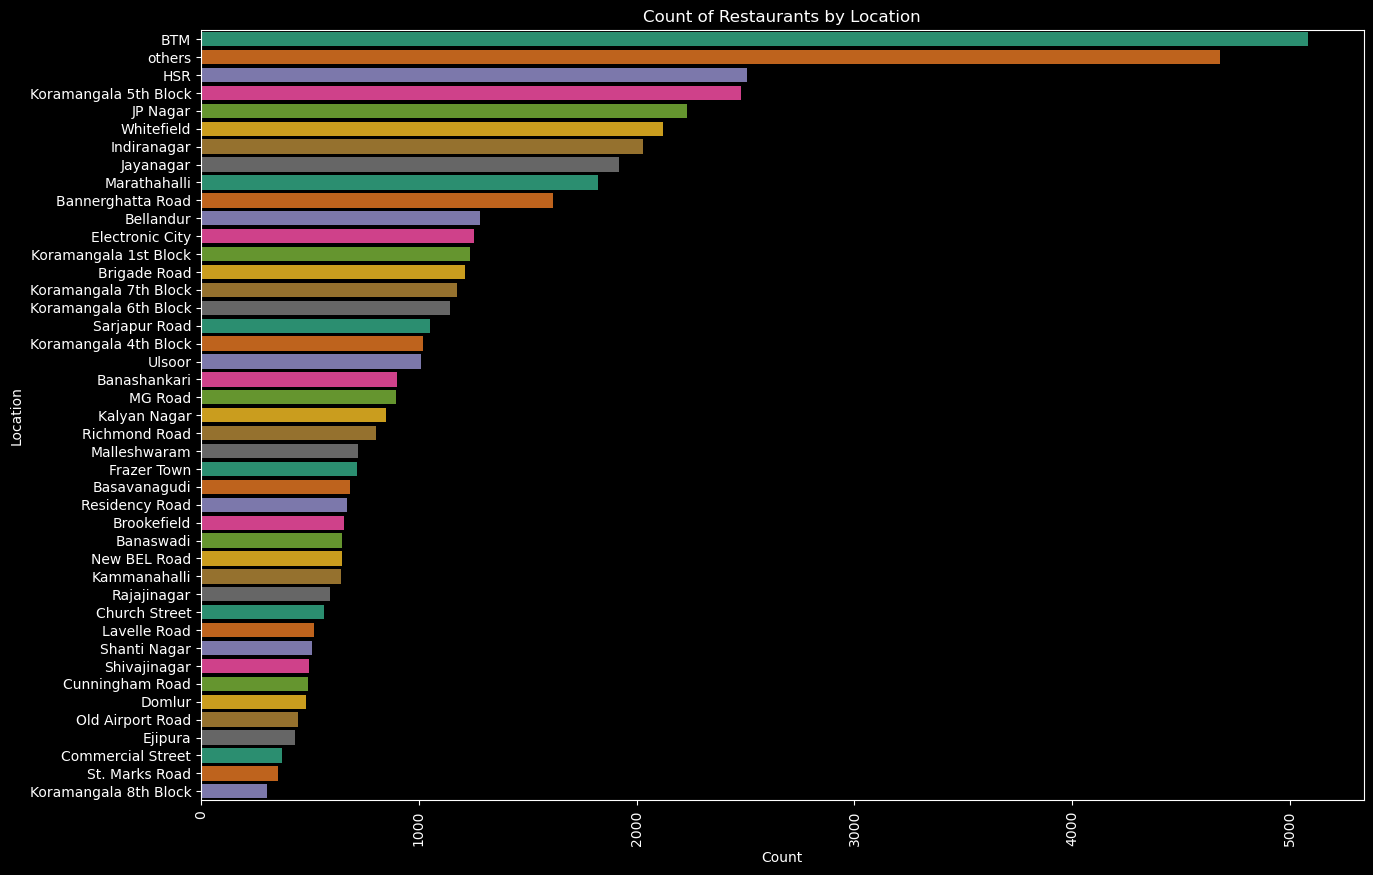

In [34]:
plt.figure(figsize=(15, 10))
sns.countplot(y='location', data=df, palette='Dark2', order=df['location'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Count')
plt.ylabel('Location')
plt.title('Count of Restaurants by Location')
plt.show()

### **Conclusions from Above Visualisation:-**
1.   The are already many restaurants in BTM Koramanagala 5th BLock, HSR, Jp Nagar. So, if i want to open a restaurant then i should not open it in these places.
2.   If I want to open a restaurant then, I should open it in St. Marks Road, Commercial Street, Ejipura where there are already very few restaurants. So, there are chances that my business will grow.

## Visualising Type

In [35]:
df['Type'].nunique()

7

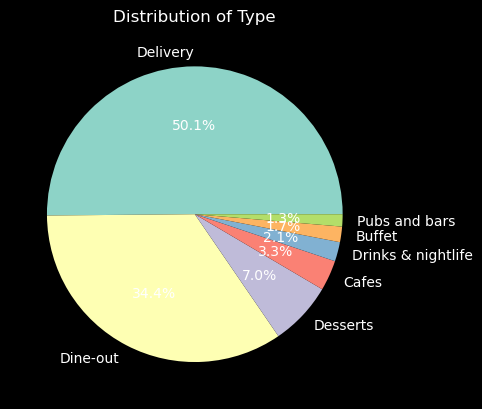

In [64]:
Type_counts = df['Type'].value_counts()

plt.pie(Type_counts, labels=Type_counts.index, autopct='%.1f%%')
plt.title('Distribution of Type')
plt.show()

## **Visualising Online Order Facility**

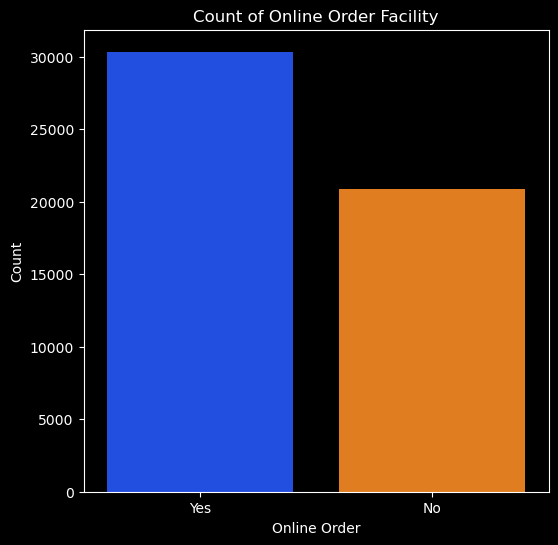

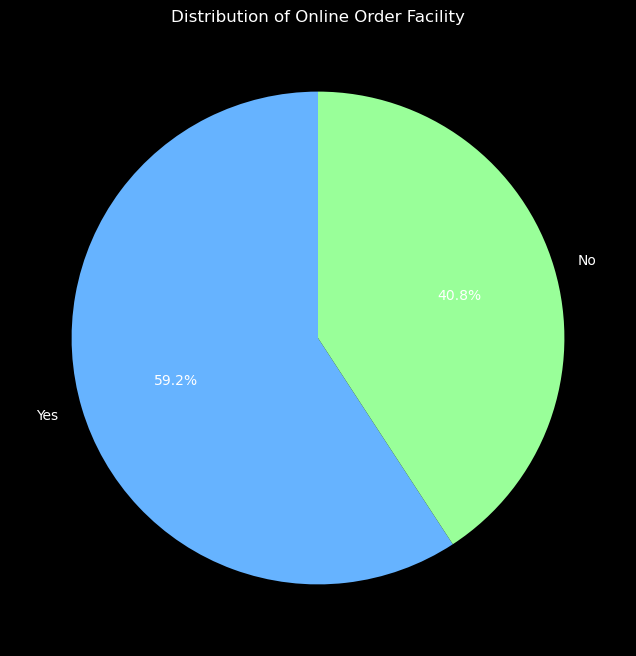

In [37]:
plt.figure(figsize=(6, 6))
sns.countplot(x='online_order', data=df, palette='bright')
plt.xlabel('Online Order')
plt.ylabel('Count')
plt.title('Count of Online Order Facility')
plt.show()

plt.figure(figsize=(8, 8))
df['online_order'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Distribution of Online Order Facility')
plt.ylabel('')
plt.show()


### **Conclusion from Above Visualisation:-**
1.  Most of the Restaurants are having the online order facility.
 

## Visualising Book Table Facility

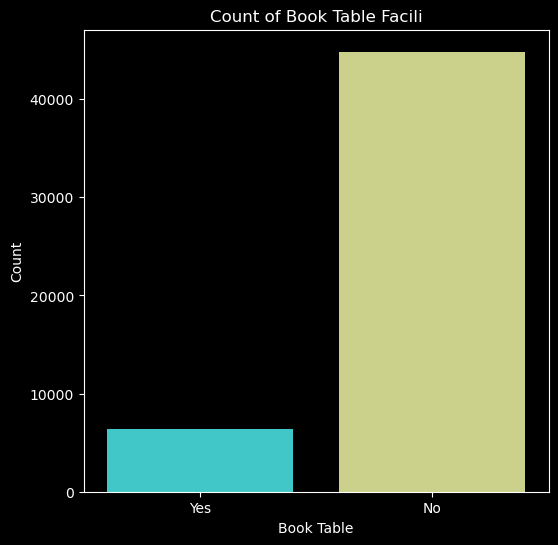

In [38]:
plt.figure(figsize=(6, 6))
sns.countplot(x='book_table', data=df, palette='rainbow')
plt.xlabel('Book Table')
plt.ylabel('Count')
plt.title('Count of Book Table Facili')
plt.show()

### **Conclusion from Above Visualisation:-**
1.  Most of the Restaurants are not having the Book Table facility.

## Visualising Online Order vs Rate

<Axes: xlabel='online_order', ylabel='rate'>

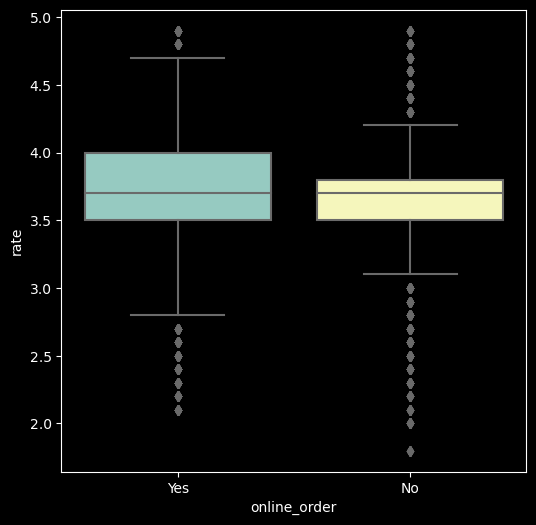

In [39]:
plt.figure(figsize = (6,6))
sns.boxplot(x= 'online_order' , y = 'rate', data = df)

### Conclusion from Above Visualisation:-
1. the Restaurants which are having the online order facility, there maximum rating is around 4.8.
2. The restaurants which are not having the online order facility, there maximum rating is around 4.2.
3. The middle line is the average rating, which is around same for both, so we can't compare it.

## Visualising Book Table V/S Rate

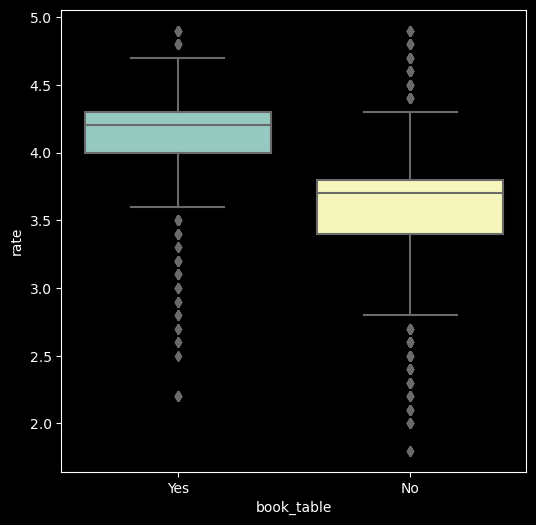

In [40]:
plt.figure(figsize = (6,6))
sns.boxplot(x = 'book_table', y= 'rate', data = df)
plt.show()

### Conclusion from Above Visualisation:-
1. the Restaurants which are having the Book Table facility, there maximum rating is around 4.7.
2. The restaurants which are not having the Book Table facility, there maximum rating is around 4.3.
3. The Restaurants which are having the Book Table facility, their Average Rating is higher than the restaurants which are not having the Book Table facility
4. If I am opening a new restaurant Then I should keep in mind that I should provide a book table facility because their average rating is high.

## Visualising Online Order Facility, Location Wise

In [41]:
df1 = df.groupby(['location','online_order'])['name'].count()
df1.to_csv('location_online.csv')
df1 = pd.read_csv('location_online.csv')
df1 = pd.pivot_table(df1, values=None, index = ['location'], columns = ['online_order'],fill_value=0, aggfunc=np.sum)
df1

name      
online_order             No   Yes
location                         
BTM                    1763  3320
Banashankari            397   505
Banaswadi               310   338
Bannerghatta Road       691   924
Basavanagudi            243   441
Bellandur               523   760
Brigade Road            552   658
Brookefield             239   417
Church Street           226   340
Commercial Street       228   142
Cunningham Road         168   322
Domlur                  247   235
Ejipura                 214   219
Electronic City         680   574
Frazer Town             287   427
HSR                     587  1919
Indiranagar             699  1332
JP Nagar                912  1317
Jayanagar               554  1364
Kalyan Nagar            352   496
Kammanahalli            264   380
Koramangala 1st Block   384   852
Koramangala 4th Block   459   558
Koramangala 5th Block   866  1613
Koramangala 6th Block   445   697
Koramangala 7th Block   389   785
Koramangala 8th Block    90   212
Lavelle Road            315   203
MG Road                 520   373
Malleshwaram            309   412
Marathahalli            717  1106
New BEL Road            255   392
Old Airport Road        227   216
Rajajinagar             286   305
Residency Road          424   247
Richmond Road           557   246
Sarjapur Road           325   728
Shanti Nagar            289   219
Shivajinagar            354   144
St. Marks Road          185   167
Ulsoor                  389   622
Whitefield              992  1129
others                 1988  2689

<Axes: xlabel='location'>

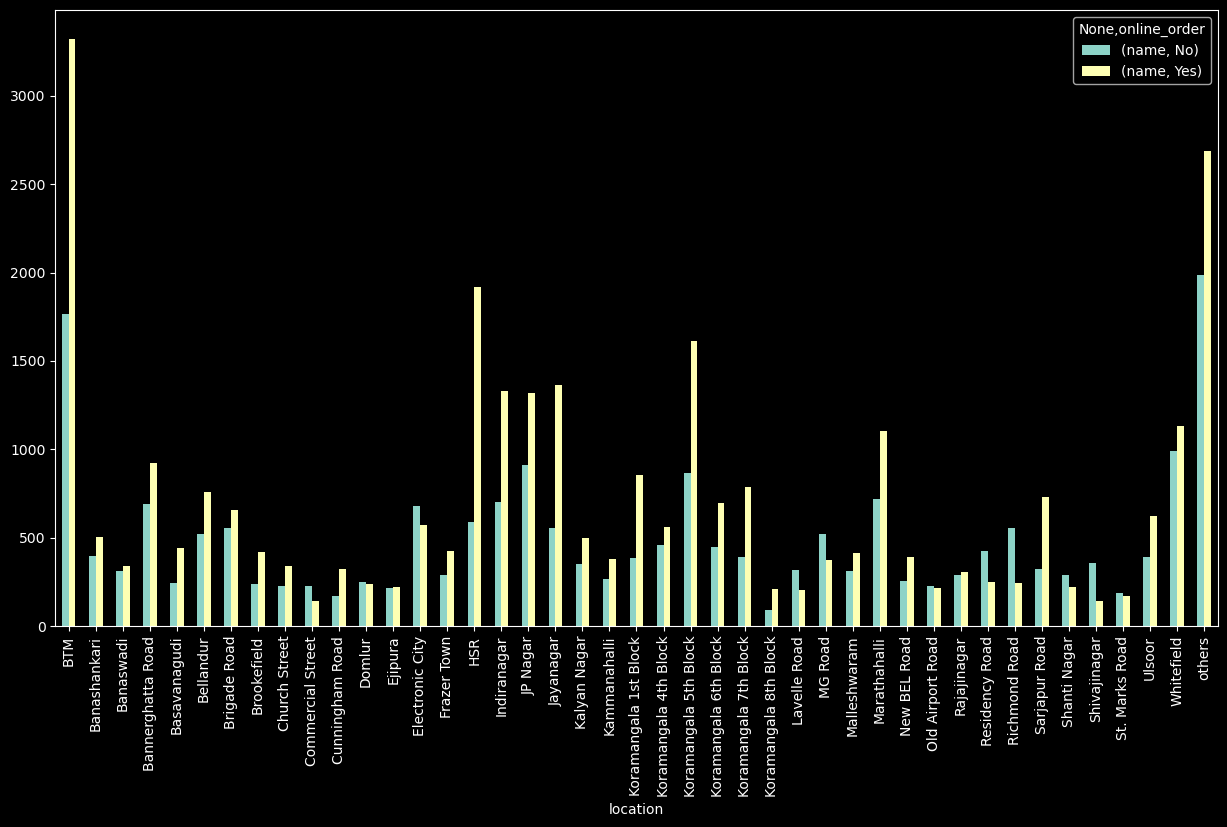

In [42]:
df1.plot(kind = 'bar', figsize = (15,8))

### Conclusion from Above Visualisation:-
1. If I want to open a restaurant with Online order facility, then I should open it in Lavelle Road. Because there are less number of restaurant providing Online order facility there. So there may be chances that my restaurant will grow.

## Visualising Book Table Facility, Location Wise 

In [43]:
df2 = df.groupby(['location','book_table'])['name'].count()
df2.to_csv('location_booktable.csv')
df2 = pd.read_csv('location_booktable.csv')
df2 = pd.pivot_table(df2, values=None, index = ['location'], columns = ['book_table'],fill_value=0, aggfunc=np.sum)
df2

name     
book_table               No  Yes
location                        
BTM                    4916  167
Banashankari            839   63
Banaswadi               640    8
Bannerghatta Road      1516   99
Basavanagudi            668   16
Bellandur              1185   98
Brigade Road           1034  176
Brookefield             582   74
Church Street           385  181
Commercial Street       370    0
Cunningham Road         315  175
Domlur                  427   55
Ejipura                 433    0
Electronic City        1156   98
Frazer Town             706    8
HSR                    2289  217
Indiranagar            1583  448
JP Nagar               1914  315
Jayanagar              1639  279
Kalyan Nagar            699  149
Kammanahalli            595   49
Koramangala 1st Block  1186   50
Koramangala 4th Block   695  322
Koramangala 5th Block  1787  692
Koramangala 6th Block  1030  112
Koramangala 7th Block  1012  162
Koramangala 8th Block   285   17
Lavelle Road            290  228
MG Road                 546  347
Malleshwaram            632   89
Marathahalli           1660  163
New BEL Road            591   56
Old Airport Road        384   59
Rajajinagar             550   41
Residency Road          522  149
Richmond Road           687  116
Sarjapur Road           899  154
Shanti Nagar            451   57
Shivajinagar            475   23
St. Marks Road          228  124
Ulsoor                  834  177
Whitefield             1868  253
others                 4327  350

<Axes: xlabel='location'>

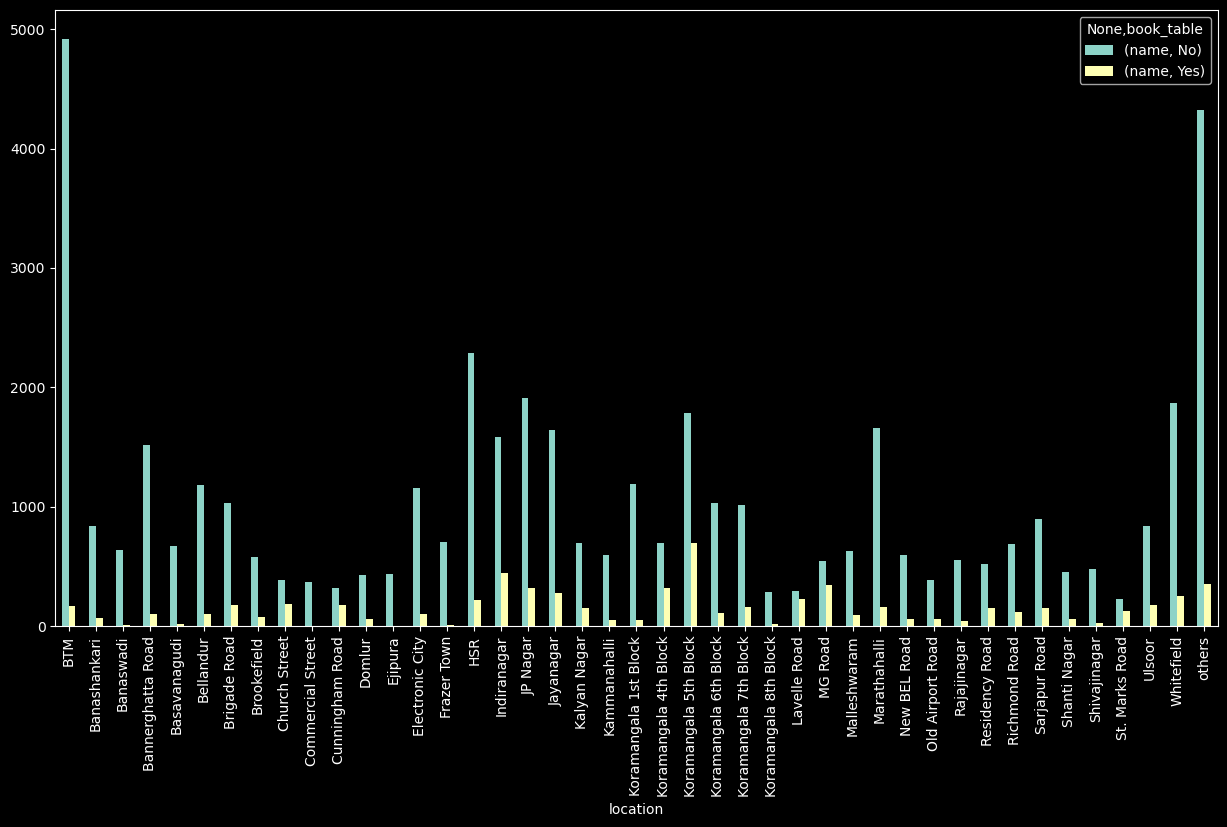

In [44]:
df2.plot(kind = 'bar', figsize = (15,8))

### Conclusions from Above Visualisation:-
1. If I want to open a restaurant with Book Table facility, then I can open it in BTM. Because there are very less number of restaurants providing Book Table facility there. But BTM is already having so many restaurants there. So I should not open it there. I can open it in HSR .If I will open a restaurant that provide Book Table Facility in HSR .So there may be chances that my restaurant wil grow, because competition is less for booking the Table.
2. If some couples want to book a table they will be chooosing your restaurant, because many restaurants are not there which provide the facility of booking the table. 

## Visualising Types of Restaurants VS Rate

<Axes: xlabel='Type', ylabel='rate'>

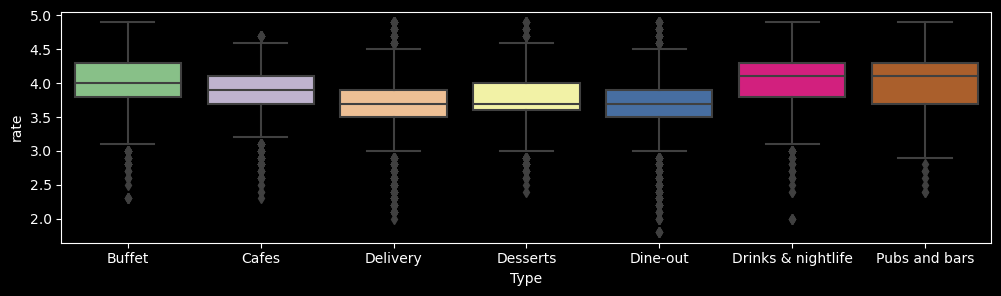

In [45]:
plt.figure(figsize = (12, 3))
sns.boxplot(x = 'Type', y = 'rate', data = df, palette = 'Accent')

### Conclusions from Above Visualisation:-
1. Maximum Average rating is given to Drinks and Nightlife type of restaurants. That means people are visiting these types of restaurants, and they are rating them as very high.
2. People are loving the Drinks and Nightlife, Pubs and Bars, and Buffet type of restaurants. So If you want to open a restaurant you can open it in any of the above type of fields.
3. Minimum average Rating is given to the Delivery type of restaurants.


## Visualising Types of Restaurants VS 2PlatesCost

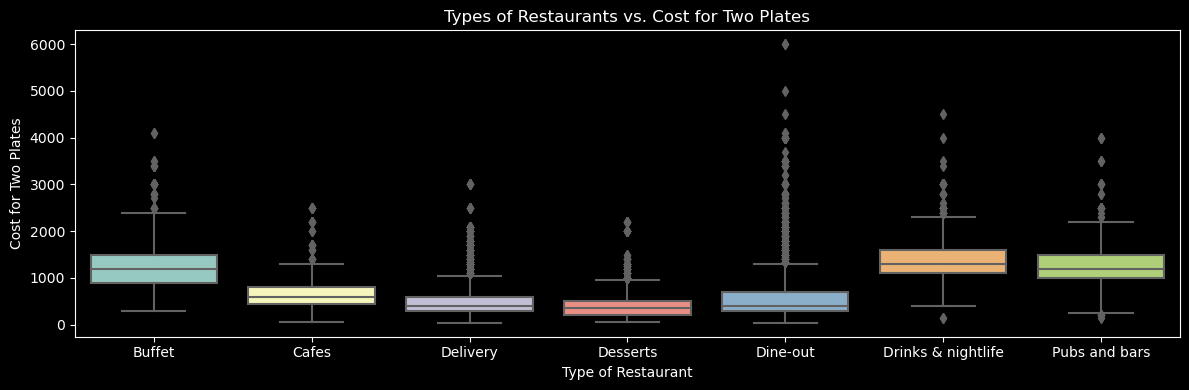

In [46]:
plt.figure(figsize=(12, 4))

sns.boxplot(data=df, x='Type', y='2PlatesCost')

plt.title('Types of Restaurants vs. Cost for Two Plates')
plt.xlabel('Type of Restaurant')
plt.ylabel('Cost for Two Plates')

plt.tight_layout()
plt.show()

### Conclusions from Above Visualisation:
1. High-End Segment: If aiming for an upscale clientele, consider opening a buffet, dine-out, drinks & nightlife, or pubs & bars establishment. These types have higher median costs and appeal to customers willing to pay a premium for a quality dining experience.
2. Affordable Options: For targeting budget-conscious customers, cafes and dessert parlors are ideal. They have a lower and more consistent cost range, making them accessible to a broader audience.

## Grouping Types of Restaurants, location wise

In [47]:
df3 = df.groupby(['location','Type'])['name'].count()
df3.to_csv('location_Type.csv')
df3 = pd.read_csv('location_Type.csv')
df3 = pd.pivot_table(df3, values=None, index=['location'], columns=['Type'], fill_value=0, aggfunc=np.sum)
df3

name                                   \
Type                  Buffet Cafes Delivery Desserts Dine-out   
location                                                        
BTM                       21    83     3072      198     1668   
Banashankari               7    36      418       71      356   
Banaswadi                  0    24      314       37      266   
Bannerghatta Road          9    46      831      137      581   
Basavanagudi               7    11      344       66      251   
Bellandur                 28    36      624       77      485   
Brigade Road              25    46      497      108      455   
Brookefield                6    17      339       45      245   
Church Street             19    51      193       29      215   
Commercial Street          0    13      121       77      159   
Cunningham Road           29    34      194       26      184   
Domlur                    15    13      261       35      135   
Ejipura                    0     0      245       16      172   
Electronic City           23    24      573       71      521   
Frazer Town                1    11      470       56      172   
HSR                       19    49     1702      123      581   
Indiranagar               38    97     1096      140      529   
JP Nagar                  45    76     1157      166      727   
Jayanagar                 27    77     1043      182      577   
Kalyan Nagar               9    45      370       88      318   
Kammanahalli               2    27      332       35      242   
Koramangala 1st Block      3    26      716       70      398   
Koramangala 4th Block     21    53      464       81      302   
Koramangala 5th Block     65   146     1075      209      842   
Koramangala 6th Block     18    43      522       70      415   
Koramangala 7th Block     25    52      503      127      417   
Koramangala 8th Block      0    10      203       24       63   
Lavelle Road              30    27      127       50      191   
MG Road                   51    76      266       68      343   
Malleshwaram              11    31      269       85      291   
Marathahalli              34    32      989      105      639   
New BEL Road               4    29      340       34      224   
Old Airport Road          12     5      202       37      166   
Rajajinagar               10     4      258       55      251   
Residency Road            20    31      187       63      289   
Richmond Road             63    21      257       78      356   
Sarjapur Road             25    22      560       82      323   
Shanti Nagar               9    22      198       39      229   
Shivajinagar               6    17      143       37      280   
St. Marks Road             5    10      115       10      150   
Ulsoor                    16    56      456       71      359   
Whitefield                28    51     1050      138      774   
others                    83   123     2600      252     1499   

                                                        
Type                  Drinks & nightlife Pubs and bars  
location                                                
BTM                                   22            19  
Banashankari                          14             0  
Banaswadi                              6             1  
Bannerghatta Road                      9             2  
Basavanagudi                           5             0  
Bellandur                             17            16  
Brigade Road                          57            22  
Brookefield                            4             0  
Church Street                         36            23  
Commercial Street                      0             0  
Cunningham Road                       16             7  
Domlur                                12            11  
Ejipura                                0             0  
Electronic City                       21            21  
Frazer Town                            2             2  
HSR    

<Axes: xlabel='location'>

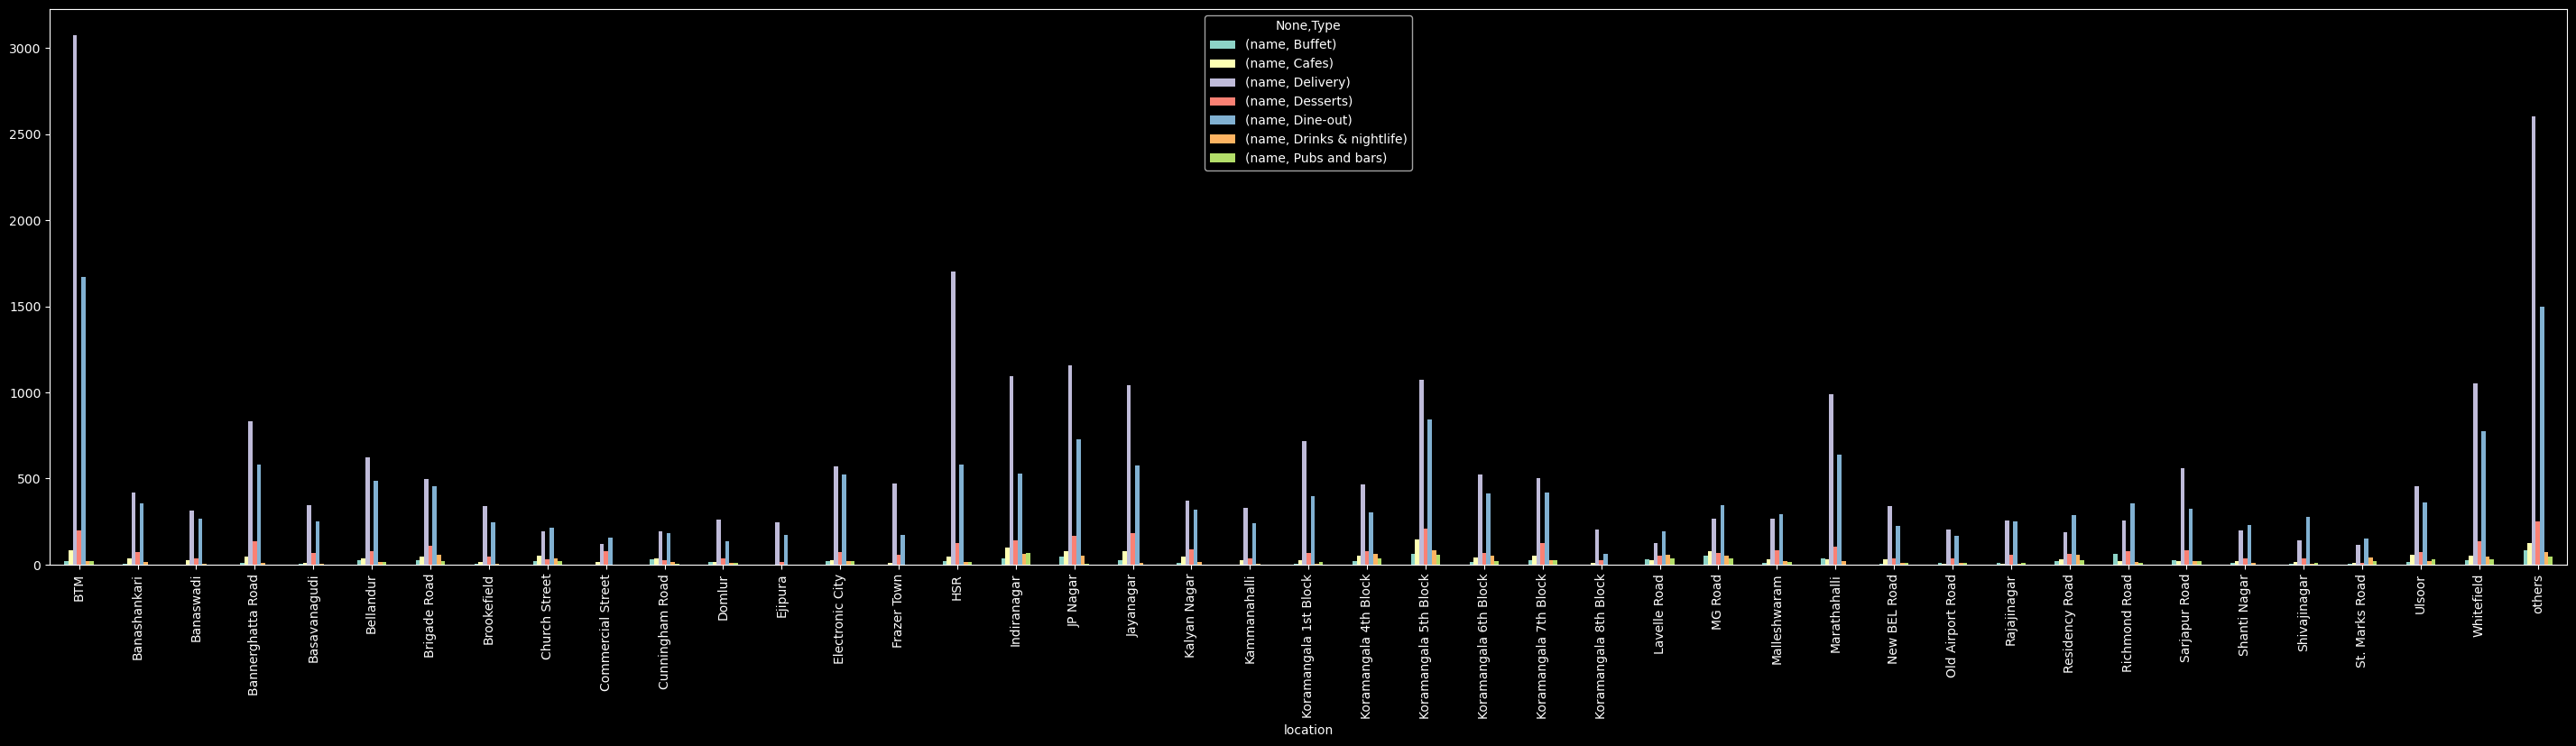

In [48]:
df3.plot(kind = 'bar', figsize = (36,8))

### Conclusions from Above Visualisation:-
1. If I want to open a Pub and Bar, I shoould choose that location where Pubs and Bars are very few in number. So In Shivaji Nagar Pubs and Bars are not much in quantity, the Green colour bar is very small. Shanti Nagar is another such place where you can open. 

## No. of Votes, Location Wise

In [49]:
df4 = df[['location', 'votes']]
df4.drop_duplicates()
df5 = df4.groupby(['location'])['votes'].sum()
df5 = df5.to_frame()
df5 = df5.sort_values('votes', ascending=False)
df5.head()

,votes
location,
Koramangala 5th Block,2214083
Indiranagar,1166035
Koramangala 4th Block,685156
Church Street,590306
JP Nagar,586583


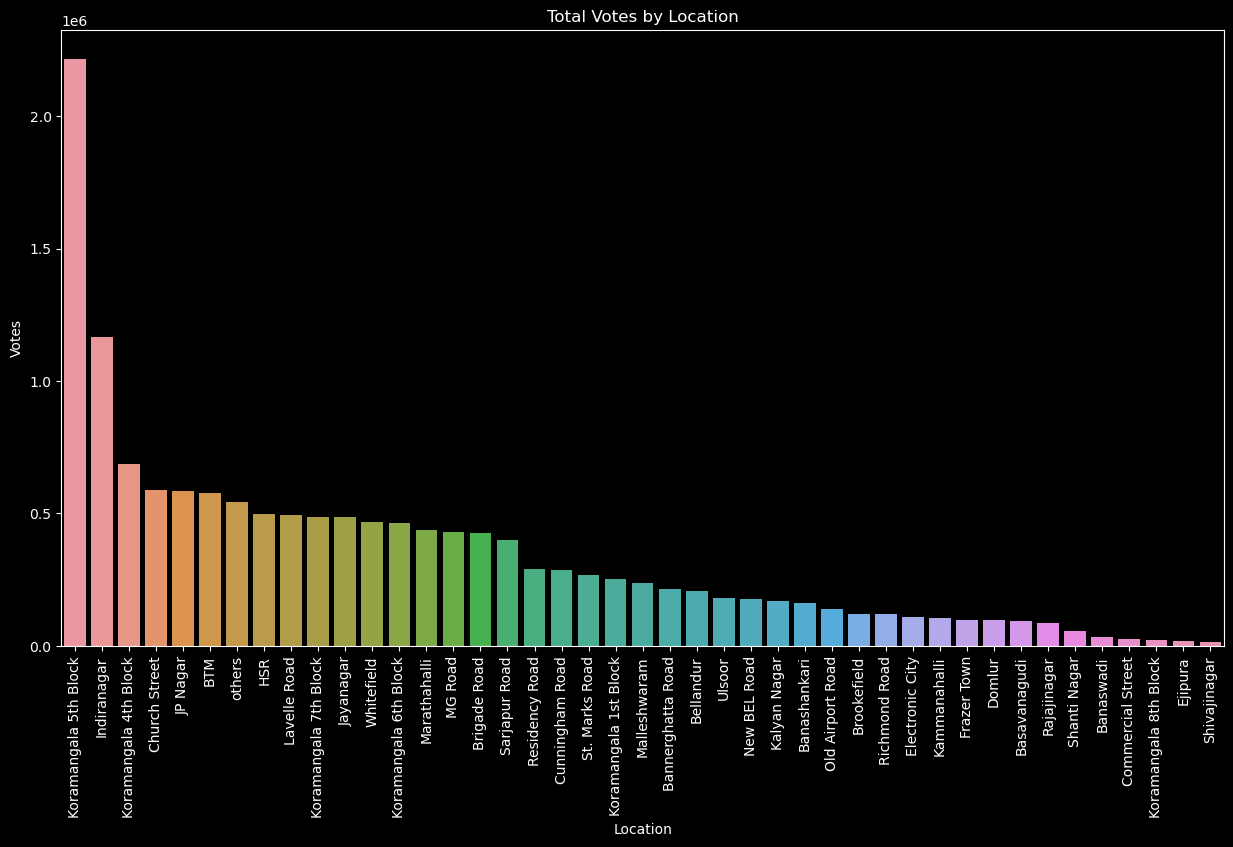

In [50]:
plt.figure(figsize=(15, 8))
sns.barplot(x=df5.index, y=df5['votes'])
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Votes')
plt.title('Total Votes by Location')
plt.show()

### Conclusions from Above Visualisation:-
1. In Koramangala 5th Block votes are maximum, that means people in this area are interested in voting.So if you open a restaurant in this block, then you will get a very good customer feedback.
2. Similarly in Indiranagar also people are interested. 
3. In Shivaji Nagar votes are very less, maybe people there are not interested in voting or the restaurants are very less there.

## Visualizing Top Cuisines

In [51]:
df.tail()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
51712,Best Brews - Four Points by Sheraton Bengaluru...,No,No,3.600000,27,Whitefield,Continental,1500.0,Pubs and bars
51713,Vinod Bar And Restaurant,No,No,3.700142,0,Whitefield,Finger Food,600.0,Pubs and bars
51714,Plunge - Sheraton Grand Bengaluru Whitefield H...,No,No,3.700142,0,Whitefield,Finger Food,2000.0,Pubs and bars
51715,Chime - Sheraton Grand Bengaluru Whitefield Ho...,No,Yes,4.300000,236,others,Finger Food,2500.0,Pubs and bars
51716,The Nest - The Den Bengaluru,No,No,3.400000,13,others,others,1500.0,Pubs and bars


In [52]:
df6 = df[['cuisines', 'votes']]
df6.drop_duplicates()
df7 = df6.groupby(['cuisines'])['votes'].sum()
df7 = df7.reset_index() 
df7 = df7.sort_values('votes', ascending=False)
df7.head()

,cuisines,votes
69,others,11547349
43,North Indian,517198
45,"North Indian, Chinese",259318
60,South Indian,161975
53,"North Indian, Mughlai",103706


In [53]:
df7 = df7.iloc[1:, :]
df7.head()

,cuisines,votes
43,North Indian,517198
45,"North Indian, Chinese",259318
60,South Indian,161975
53,"North Indian, Mughlai",103706
21,Chinese,101728


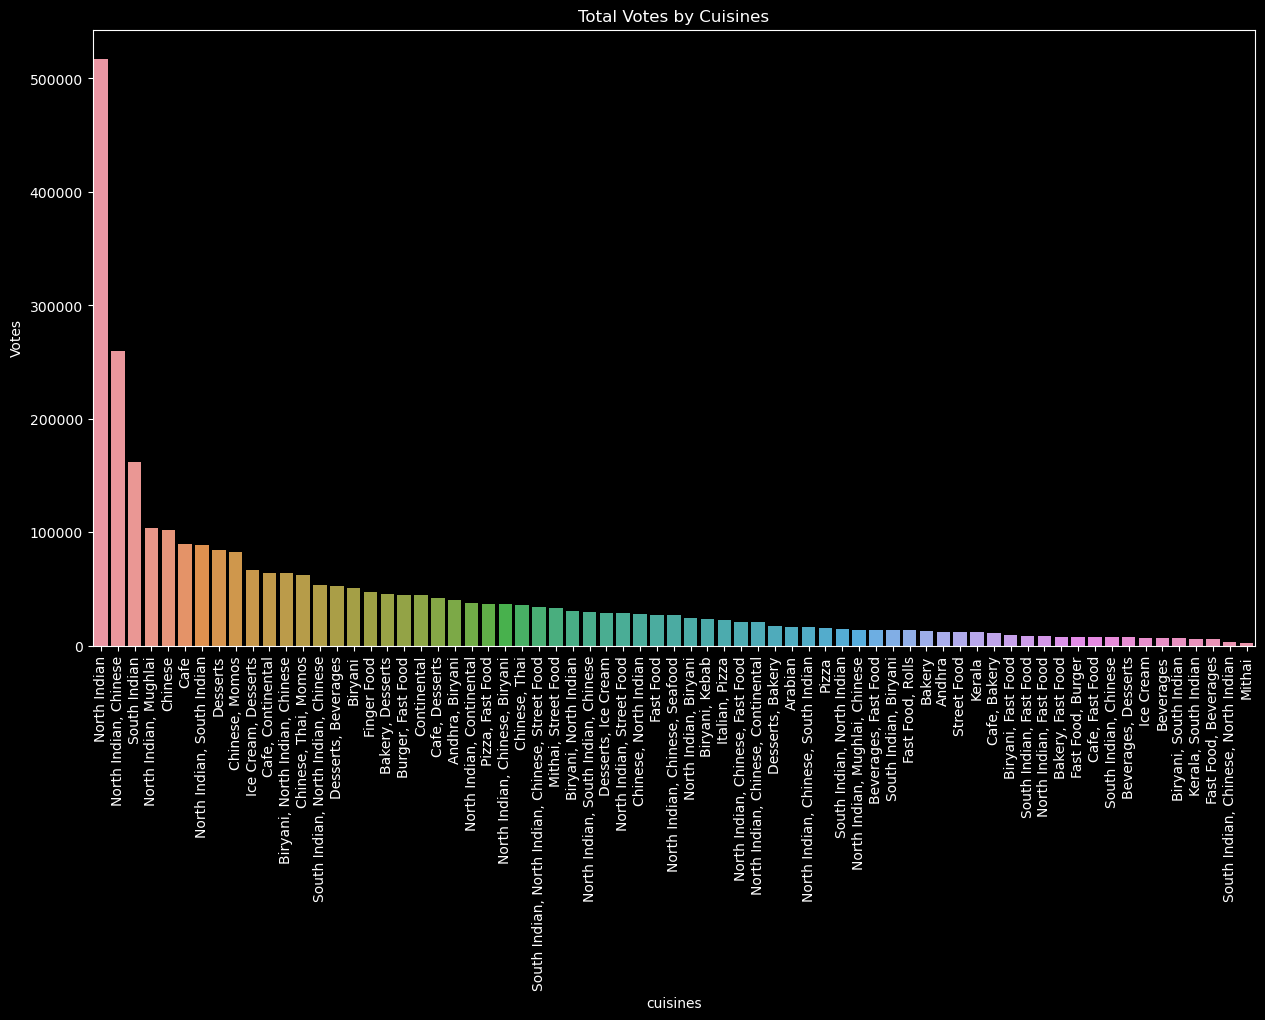

In [54]:
plt.figure(figsize=(15, 8))
sns.barplot(x=df7['cuisines'], y=df7['votes'])
plt.xticks(rotation=90)
plt.xlabel('cuisines')
plt.ylabel('Votes')
plt.title('Total Votes by Cuisines')
plt.show()

### Conclusions from Above Visualisation:-
1. If you want to open a Special Type of Cuisine, then you can go for North Indian, North Indian + Chinese or South Indian. Because these are the ones having the most number of votes.

## Cost Analysis by Location:

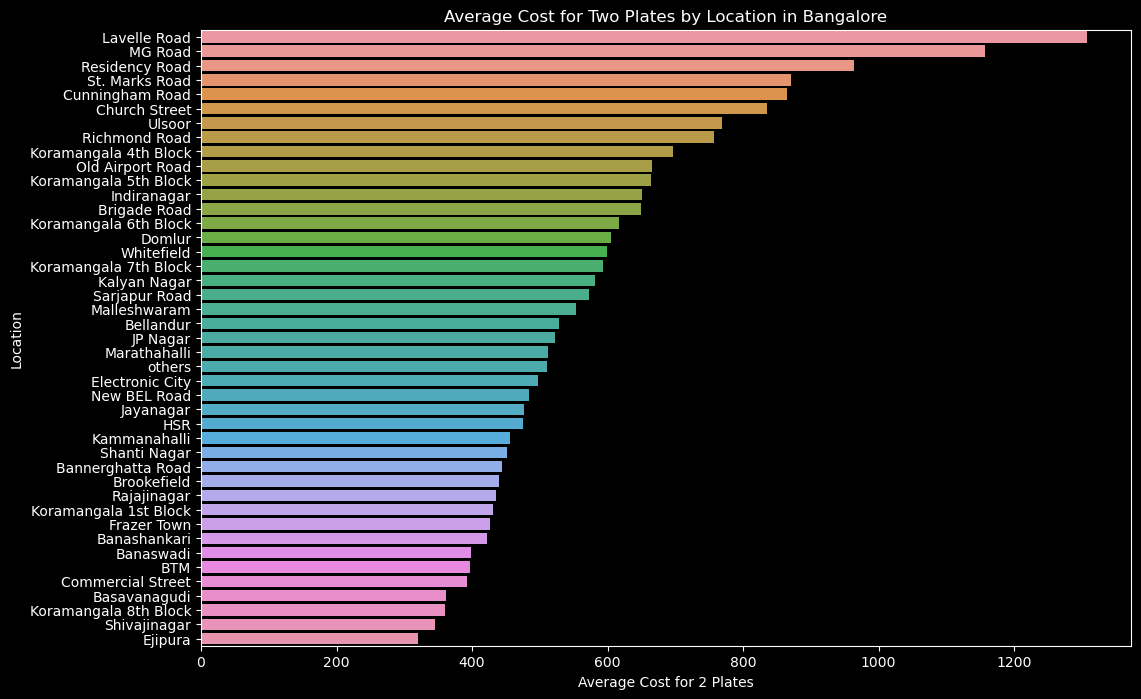

In [55]:
#Analyzing the average cost for two plates across different locations to see if there are areas that are generally more expensive.

avg_cost_by_location = df.groupby('location')['2PlatesCost'].mean().sort_values(ascending=False)
avg_cost_by_location
plt.figure(figsize=(12, 8))
sns.barplot(x=avg_cost_by_location.values, y=avg_cost_by_location.index)
plt.xlabel('Average Cost for 2 Plates')
plt.ylabel('Location')
plt.title('Average Cost for Two Plates by Location in Bangalore')
plt.show()


### Conclusions from Above Visualisation:-
1. Top Locations: Lavelle Road, MG Road, and Residency Road are the most expensive locations for dining, with average costs for two plates exceeding 1200 INR. Given the high average cost, customers in these areas are likely to be more affluent and willing to spend on premium dining experiences. However, expect higher rental costs and competition. Ensure your restaurant offers a unique, high-quality experience to justify the premium pricing.
2. Mid-range Locations: Locations like Koramangala 4th Block, Old Airport Road, and Indiranagar fall in the mid-range, with average costs between 600-800 INR. They attract a diverse crowd, including young professionals and families. You can position your restaurant as a place offering good value for money with a blend of quality and affordability. Consider offering a mix of both gourmet and casual dining options to appeal to a broad customer base.
3. Affordable Locations: Locations such as Shivajinagar, Ejipura, and BTM are more affordable, with average costs below 400 INR. The lower average cost suggests a focus on affordability and volume. Catering to students, working professionals, and families looking for economical dining options could be beneficial. Consider focusing on efficiency, quick service, and value for money.

In [56]:
df.head()

,name,online_order,book_table,rate,votes,location,cuisines,2PlatesCost,Type
0,Jalsa,Yes,Yes,4.1,775,Banashankari,"North Indian, Mughlai, Chinese",800.0,Buffet
1,Spice Elephant,Yes,No,4.1,787,Banashankari,others,800.0,Buffet
2,San Churro Cafe,Yes,No,3.8,918,Banashankari,others,800.0,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7,88,Banashankari,"South Indian, North Indian",300.0,Buffet
4,Grand Village,No,No,3.8,166,Basavanagudi,others,600.0,Buffet
